In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import aic, bic
import itertools
import warnings

In [182]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [183]:
cd C:\Users\Iulia\Desktop\CreditRisk

C:\Users\Iulia\Desktop\CreditRisk


In [184]:
data = pd.read_csv('DTSE_AIS_unemployment_task_data.csv')

In [185]:
data['Period'] = pd.to_datetime(data['Period'])
data.set_index('Period', inplace=True)

In [186]:
# calculate the percentage of missing values in each column
# missing_percentages = df.isna().mean() * 100
missing_percentages = data.isin([np.nan]).mean() * 100
# sort the columns by percentage of missing values, descending
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
# select the top columns with missing values (adjust the number as needed)
top_missing_percentages = round(sorted_missing_percentages,4).head(15)
# print the top columns with their percentage of missing values
print(top_missing_percentages)

data.interpolate(method='linear', inplace=True)

unemp      0.4926
realgdp    0.0000
pop        0.0000
infl       0.0000
dtype: float64


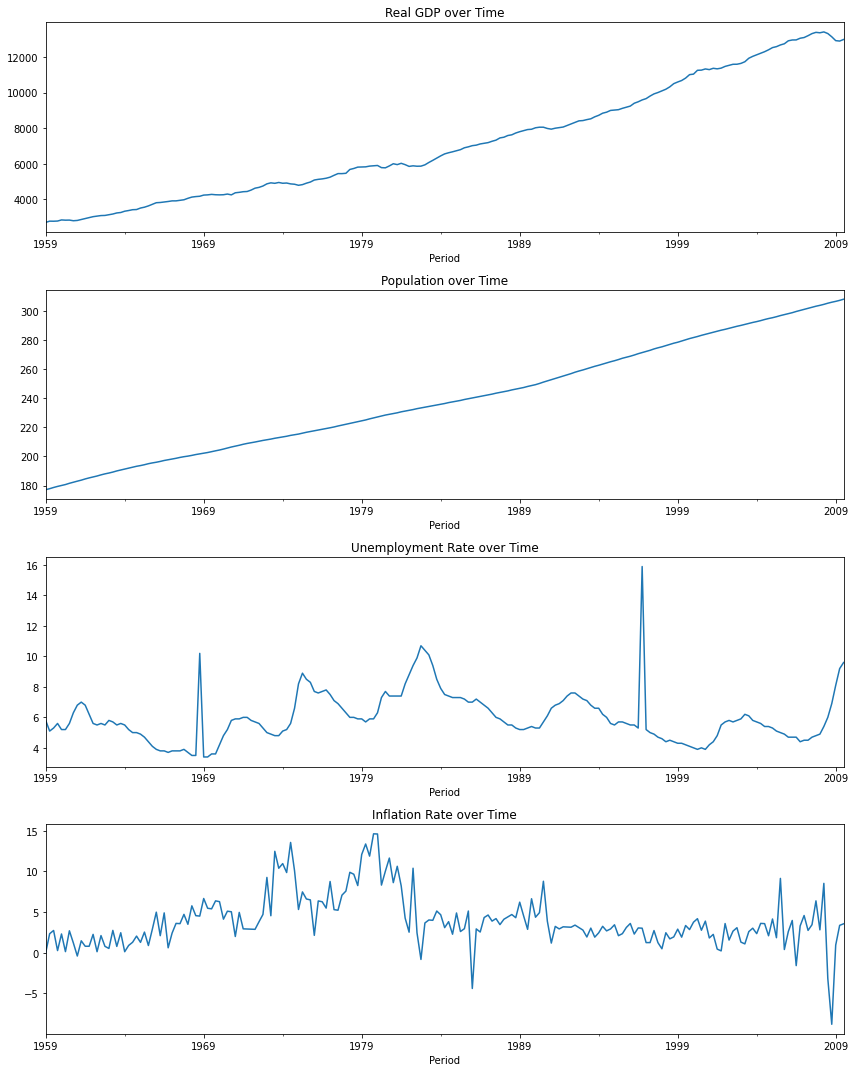

In [187]:
# Plotting each column to see the trend over time
fig, ax = plt.subplots(4, 1, figsize=(12, 15))

data['realgdp'].plot(ax=ax[0], title='Real GDP over Time')
data['pop'].plot(ax=ax[1], title='Population over Time')
data['unemp'].plot(ax=ax[2], title='Unemployment Rate over Time')
data['infl'].plot(ax=ax[3], title='Inflation Rate over Time')

plt.tight_layout()
plt.show()

In [188]:
# Specify the variables to winsorize
variables_to_winsorize = ['unemp'] 

# Apply winsorization to each variable
for variable in variables_to_winsorize:
    data[variable] = winsorize(data[variable], limits=[0.05, 0.05])

In [189]:
# granger causality test to check the causal relationship among variables
maxlag=8
variables=data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(data[[row, col]], maxlag=20, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]
print(matrix)

           realgdp_x   pop_x  unemp_x  infl_x
realgdp_y     1.0000  0.0194   0.2091  0.0117
pop_y         0.1384  1.0000   0.0377  0.0018
unemp_y       0.0000  0.1063   1.0000  0.0006
infl_y        0.0782  0.0311   0.5617  1.0000


In [190]:
data = data.drop(['pop'],axis=1) # drop 'pop' because it has p-value>0.05 

In [191]:
# Augmented Dickey-Fuller Test for Stationarity
for variable in data.columns:
    result = adfuller(data[variable])
    print(f'Variable: {variable}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    is_stationary = result[1] <= 0.05
    print(f'Stationary: {is_stationary}')
    print('-' * 40)

Variable: realgdp
ADF Statistic: 1.7504627967647166
p-value: 0.9982455372335032
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612
Stationary: False
----------------------------------------
Variable: unemp
ADF Statistic: -2.4627491723568506
p-value: 0.12480287353208053
Critical Values:
   1%: -3.4633090972761744
   5%: -2.876029332045744
   10%: -2.5744932593252643
Stationary: False
----------------------------------------
Variable: infl
ADF Statistic: -3.0545144962572364
p-value: 0.03010762086348588
Critical Values:
   1%: -3.463476079125
   5%: -2.876102355
   10%: -2.574532225
Stationary: True
----------------------------------------


In [192]:
data_orig=data.copy()

In [193]:
# Define a function to check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    return result[1] <= 0.05  # Returns True if stationary

# Define the maximum number of differencing attempts
max_differencing_attempts = 3  # You can adjust this as needed

# Iterate through columns and perform differencing until stationary
for variable in data.columns:
    print(f'Variable: {variable}')
    
    differencing_attempts = 0
    is_stationary = check_stationarity(data[variable])
    
    while not is_stationary and differencing_attempts < max_differencing_attempts:
        data[variable] = data[variable].diff()
        data.dropna(inplace=True)  # Drop missing values
        
        differencing_attempts += 1
        is_stationary = check_stationarity(data[variable])
    
    if is_stationary:
        print(f'Stationary after {differencing_attempts} differencing attempt(s)')
    else:
        print(f'Variable remains non-stationary after {differencing_attempts} differencing attempt(s)')

# The 'data' DataFrame now contains differenced variables (some may still be non-stationary)

Variable: realgdp
Stationary after 1 differencing attempt(s)
Variable: unemp
Stationary after 1 differencing attempt(s)
Variable: infl
Stationary after 0 differencing attempt(s)


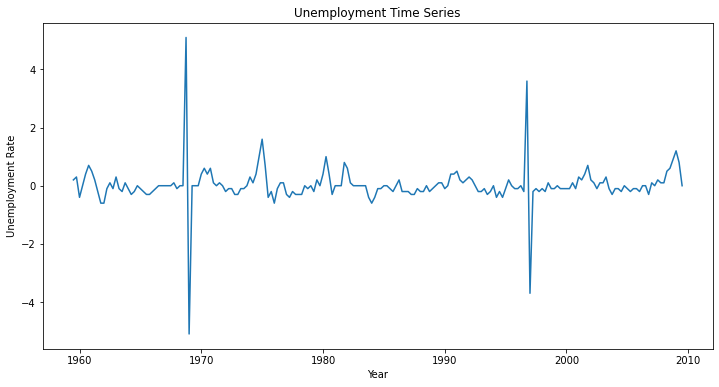

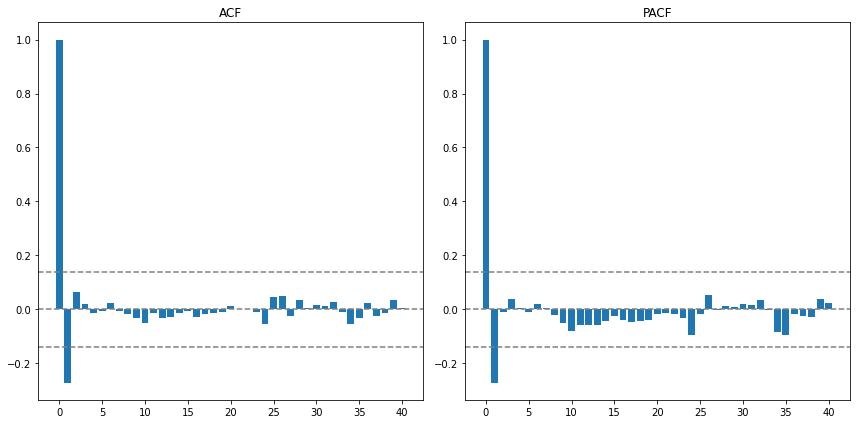

In [194]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['unemp'])
plt.title('Unemployment Time Series')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.show()

# Calculate ACF and PACF
lag_acf = acf(data['unemp'], nlags=40)
lag_pacf = pacf(data['unemp'], nlags=40, method='ols')

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(range(len(lag_acf)), lag_acf)
plt.title('ACF')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')

plt.subplot(122)
plt.bar(range(len(lag_pacf)), lag_pacf)
plt.title('PACF')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')

plt.tight_layout()
plt.show()

# Differencing to make the series stationary (if necessary)
# data['diff_unemp'] = diff(data['unemp'], k_diff=1)

### Sarimax Model (Univariate)

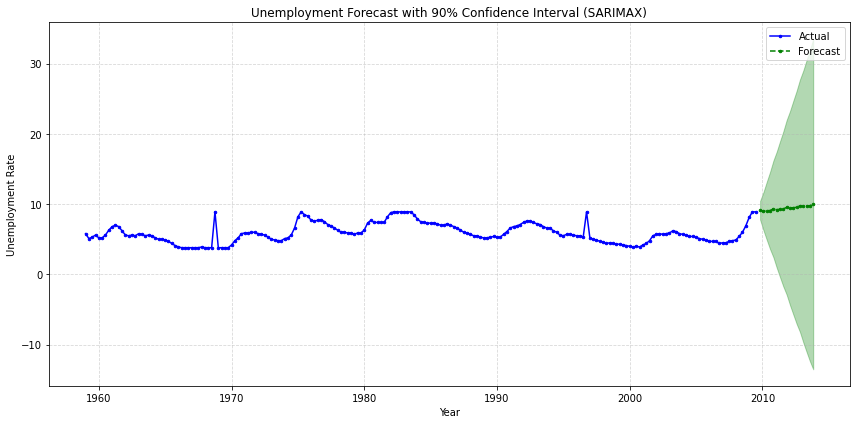

In [195]:
# Specify the variables you want to include in the model
variables = ['unemp', 'realgdp', 'infl']  # Add other variables as needed

# Train the SARIMAX model with differenced data
model = SARIMAX(data['unemp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))  # Use 'data_diff' for differenced data
results_sarimax = model.fit(disp=False)

# Forecast future differences for 'unemp'
forecast_start = data.index[-1] + pd.DateOffset(months=3)
forecast_end = pd.to_datetime('2013-10-01')  # Extend the forecast to a later date
forecast_steps = (forecast_end - forecast_start).days // 90 + 1
forecast_unemp_diff = results_sarimax.forecast(steps=forecast_steps)

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=forecast_start, periods=forecast_steps, freq='3M')

# Reverse the differenced forecasted values to the original scale
forecast_unemp_sarimax = data_orig['unemp'].iloc[-1] + forecast_unemp_diff.cumsum()

# Create a nicer plot
plt.figure(figsize=(12, 6))
plt.plot(data_orig.index, data_orig['unemp'], label='Actual', color='blue', linestyle='-', marker='.', markersize=5)
plt.plot(forecast_dates, forecast_unemp_sarimax, label='Forecast', color='green', linestyle='--', marker='.', markersize=5)
forecast_ci = results_sarimax.get_forecast(steps=forecast_steps).conf_int()  # Get the confidence interval for forecast
forecast_lower_unemp = data_orig['unemp'].iloc[-1] + forecast_ci['lower unemp'].cumsum()
forecast_upper_unemp = data_orig['unemp'].iloc[-1] + forecast_ci['upper unemp'].cumsum()
plt.fill_between(forecast_dates, forecast_lower_unemp, forecast_upper_unemp, color='green', alpha=0.3)
plt.title('Unemployment Forecast with 90% Confidence Interval (SARIMAX)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()  # Ensure all elements are within the plot area
plt.show()

### Varmax Model (Multivariate)

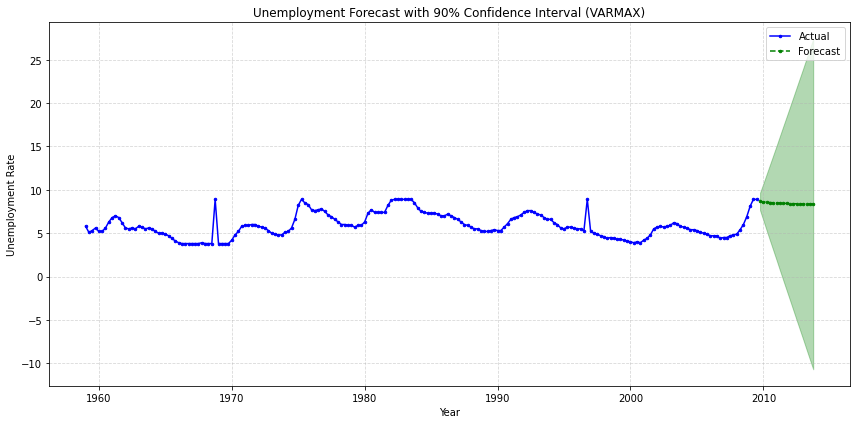

Best VARMAX Model Order: (1, 1)


In [196]:
# Specify the variables you want to include in the model
variables = ['unemp', 'realgdp', 'infl'] 

# Define the range of p and q values for VARMAX
p_values = range(0, 3)  # AutoRegressive (AR) order
q_values = range(0, 3)  # Moving Average (MA) order

# Initialize variables for best model selection
best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Loop through different combinations of hyperparameters
for p, q in itertools.product(p_values, q_values):
    try:
        # Train VARMAX model
        model = VARMAX(data[variables], order=(p, q))
        results = model.fit(disp=False)
        
        # Calculate AIC and BIC
        current_aic = aic(results.llf, results.nobs, len(results.params))
        current_bic = bic(results.llf, results.nobs, len(results.params))
        
        # Update best criteria and parameters if improved
        if current_aic < best_aic and current_bic < best_bic:
            best_aic = current_aic
            best_bic = current_bic
            best_order = (p, q)
    except:
        continue

# Train the best VARMAX model
best_model = VARMAX(data[variables], order=best_order)
results_best = best_model.fit(disp=False)

# Forecast future differences for 'unemp' using the best model
forecast_start = data.index[-1] + pd.DateOffset(months=3)
forecast_end = pd.to_datetime('2013-10-01')
forecast_steps = (forecast_end - forecast_start).days // 90 + 1
forecast_results = results_best.get_forecast(steps=forecast_steps, alpha=0.05)

# Extract the forecasted differences for 'unemp'
forecast_unemp_diff = forecast_results.predicted_mean['unemp']

# Reverse the differenced forecasted values to the original scale
forecast_unemp_varmax = data_orig['unemp'].iloc[-1] + forecast_unemp_diff.cumsum()

# Create a nicer plot
plt.figure(figsize=(12, 6))
plt.plot(data_orig.index, data_orig['unemp'], label='Actual', color='blue', linestyle='-', marker='.', markersize=5)
plt.plot(forecast_results.predicted_mean.index, forecast_unemp_varmax, label='Forecast', color='green', linestyle='--', marker='.', markersize=5)
forecast_ci = forecast_results.conf_int(alpha=0.1)  # Specify the alpha for the confidence interval
forecast_lower_unemp = data_orig['unemp'].iloc[-1] + forecast_ci['lower unemp'].cumsum()
forecast_upper_unemp = data_orig['unemp'].iloc[-1] + forecast_ci['upper unemp'].cumsum()
plt.fill_between(forecast_results.predicted_mean.index, forecast_lower_unemp, forecast_upper_unemp, color='green', alpha=0.3)
plt.title('Unemployment Forecast with 90% Confidence Interval (VARMAX)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()  # Ensure all elements are within the plot area
plt.show()

print("Best VARMAX Model Order:", best_order)

### Ensemble Model

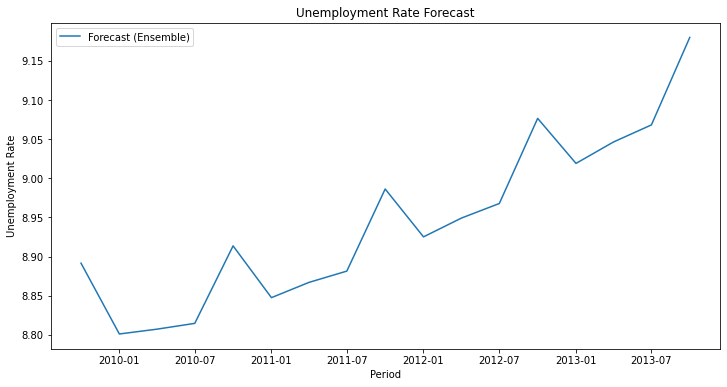

In [199]:
forecast_period = pd.date_range(start='2009-10-01', end='2013-10-01', freq='Q')
# Ensemble Forecasting
weight_varmax = 0.5  # Adjust the weights as needed
weight_sarima = 0.5
final_forecast = weight_varmax * forecast_unemp_varmax + weight_sarima * forecast_unemp_sarimax

# Create a DataFrame with the correct index
forecast_df = pd.DataFrame(final_forecast, index=final_forecast.index, columns=['unemp_forecast'])

# Visualize the Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['unemp_forecast'], label='Forecast (Ensemble)')
plt.legend()
plt.title('Unemployment Rate Forecast')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.show()

In [200]:
# Given forecasted values
unemp_forecast = 9.957664  # Forecasted unemployment rate in percentage with Ensemble (average of 2013)
pop_forecast = 299  # Forecasted population with Sarimax (average of 2013)

# Convert the unemployment rate to a decimal
unemp_forecast_decimal = unemp_forecast / 100

# Calculate the number of people in the labor force
labor_force_percentage = 0.65  # 65% of the population is in the labor force
labor_force = pop_forecast * labor_force_percentage

# Calculate the number of unemployed people
unemployed_people = labor_force * (unemp_forecast_decimal)

# Print the result
print(f"Estimated number of unemployed people in 2013: {unemployed_people:.2f}")

Estimated number of unemployed people in 2013: 19.35


### Varmax Model, but the unemployment series and the other predictors are not stationarized

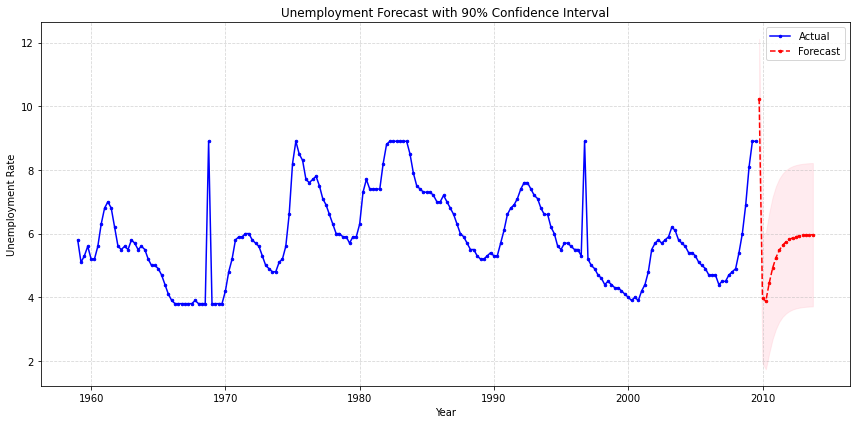

In [180]:
# Specify the variables you want to include in the model
variables = ['unemp', 'realgdp', 'infl']  

# Train the VARMAX model with multiple variables
model = VARMAX(data[variables], order=(1, 1))
results_varmax = model.fit(disp=False)

# Forecast future unemployment values along with other variables
forecast_start = data.index[-1] + pd.DateOffset(months=3)
forecast_end = pd.to_datetime('2013-10-01')
forecast_steps = (forecast_end - forecast_start).days // 90 + 1
# Forecast future unemployment values along with other variables with a smaller confidence interval (e.g., 90%)
forecast_results = results_varmax.get_forecast(steps=forecast_steps, alpha=0.05)

# Extract the forecasted values for 'unemp'
forecast_unemp = forecast_results.predicted_mean['unemp']

# Create a nicer plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['unemp'], label='Actual', color='blue', linestyle='-', marker='.', markersize=5)
plt.plot(forecast_results.predicted_mean.index, forecast_unemp, label='Forecast', color='red', linestyle='--', marker='.', markersize=5)
forecast_ci = forecast_results.conf_int(alpha=0.1)  # Specify the alpha for the confidence interval
plt.fill_between(forecast_results.predicted_mean.index, forecast_ci['lower unemp'], forecast_ci['upper unemp'], color='pink', alpha=0.3)
plt.title('Unemployment Forecast with 90% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()  # Ensure all elements are within the plot area
plt.show()